Data spillting, pre processign and feartire extraciotgn 

In [ ]:
import librosa
import noisereduce as nr
import numpy as np
import soundfile as sf
from pathlib import Path
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from glob import glob

def preprocess_audio(y, sr, target_duration=6.0, apply_preemphasis=False, apply_reduction=False, coef=0.5, normalise='rms'):
    
    # Trim leading/trailing silence
    y, _ = librosa.effects.trim(y)

    # Apply noise reduction / dereverberation
    if apply_reduction:
        y = nr.reduce_noise(y=y, sr=sr)

    # Apply pre-emphasis filter
    if apply_preemphasis:
        y = librosa.effects.preemphasis(y, coef=coef)

    # Normalisation method
    if normalise == 'rms':
        rms = np.sqrt(np.mean(y**2))
        y = y / (rms + 1e-6)
    elif normalise == 'peak':
        y = y / (np.max(np.abs(y)) + 1e-6)

    # Duration control: pad or truncate
    target_length = int(sr * target_duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)))
    else:
        y = y[:target_length]

    return y

def preprocess_folder(input_folder, output_folder, sr=22050, target_duration=6.0, apply_preemphasis=False, apply_reduction=False, coef=0.5, normalise='rms'):
    
    input_folder = Path(input_folder)
    output_folder = Path(output_folder)
    wav_files = list(input_folder.rglob("*.wav"))
    
    print(f"Found {len(wav_files)} audio files in {input_folder}")

    for wav_file in wav_files:
        try:
            y, _ = librosa.load(wav_file, sr=sr)
            y = preprocess_audio(
                y, sr, 
                target_duration=target_duration,
                apply_preemphasis=apply_preemphasis,
                apply_reduction=apply_reduction,
                coef=coef,
                normalise=normalise
            )

            # Save processed file to the same structure
            relative_path = wav_file.relative_to(input_folder)
            out_path = output_folder / relative_path
            out_path.parent.mkdir(parents=True, exist_ok=True)

            sf.write(out_path, y, sr)

        except Exception as e:
            print(f"Failed: {wav_file} → {e}")





class AudioFeatureDataset(Dataset):
    def __init__(self, base_path):
        self.base_path = base_path
        self.feature_dirs = {
            "mel": "mel_spectrogram",
            "mfcc": "mfcc",
            "chroma": "chroma",
            "tonnetz": "tonnetz",
            "contrast": "spectral_contrast"
        }

        # Collect relative paths from one feature folder (
        mel_folder = os.path.join(base_path, self.feature_dirs['mel'])
        rel_paths = glob(os.path.join(mel_folder, "*", "*", "*.npy"))
        self.valid_paths = [
            os.path.relpath(path, mel_folder)
            for path in rel_paths
        ]

        # Filter to only keep files that exist in all 5 folders
        self.valid_paths = [
            rel_path for rel_path in self.valid_paths
            if all(
                os.path.exists(os.path.join(base_path, folder, rel_path))
                for folder in self.feature_dirs.values()
            )
        ]

      
        speaker_ids = sorted(set(p.split(os.sep)[0] for p in self.valid_paths))
        self.label_map = {speaker: idx for idx, speaker in enumerate(speaker_ids)}

        print(f"[INFO] Loaded {len(self.valid_paths)} aligned samples")
        print(f"[INFO] Number of speaker classes: {len(self.label_map)}")

    def __len__(self):
        return len(self.valid_paths)

    def __getitem__(self, idx):
        rel_path = self.valid_paths[idx]
        speaker_id = rel_path.split(os.sep)[0]
        label = self.label_map[speaker_id]

        def load(feature):
            path = os.path.join(self.base_path, self.feature_dirs[feature], rel_path)
            return np.load(path)

        mfcc = torch.tensor(load("mfcc"), dtype=torch.float32).mean(dim=1)     
        chroma = torch.tensor(load("chroma"), dtype=torch.float32).mean(dim=1)  
        tonnetz = torch.tensor(load("tonnetz"), dtype=torch.float32).mean(dim=1) 
        contrast = torch.tensor(load("contrast"), dtype=torch.float32).mean(dim=1)  
        mel = torch.tensor(load("mel"), dtype=torch.float32).unsqueeze(0)  


        return mel, mfcc, chroma, tonnetz, contrast, torch.tensor(label)


In [ ]:
import os
import numpy as np
import torch


feature_root = "datasets/vox1_subset_150/features_aligned_ready"
dataset = AudioFeatureDataset(feature_root)



def check_feature_shapes(dataset, idx=0):
    print(f"\Checking sample index: {idx}\n{'='*50}")
    
    rel_path = dataset.valid_paths[idx]
    print(f"Sample path: {rel_path}")

    for feature in dataset.feature_dirs.keys():
      
        path = os.path.join(dataset.base_path, dataset.feature_dirs[feature], rel_path)
        arr = np.load(path)

        print(f"\n{feature.upper()}")
        print(f"Raw .npy shape: {arr.shape}")

       
        tensor = torch.tensor(arr, dtype=torch.float32)

        if feature == "mel":
            model_input = tensor.unsqueeze(0)  
            print(f"Model input shape (after unsqueeze): {model_input.shape}")
        else:
            try:
                reduced = tensor.mean(dim=1)
                print(f"Model input shape (after mean over time): {reduced.shape}")
            except:
                print(" Shape error in mean(dim=1). Try mean(dim=0)?")

    print("\nDone shape check.\n")



check_feature_shapes(dataset, idx=0)  


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F



class ConvolutionLSTMBlock(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.AvgPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.AvgPool2d(2)


        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.AvgPool2d(2)


        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.AdaptiveAvgPool2d((32, 8))  

        self.dropout = nn.Dropout(0.1)

        self.lstm = nn.LSTM(input_size=8 * 256, hidden_size=512,
                            num_layers=2, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        
        x = self.pool1(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)


        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = self.pool4(x)

        x = self.dropout(x)
        x = x.permute(0, 2, 1, 3).reshape(x.size(0), 32, -1)

        out, _ = self.lstm(x)
        return out[:, -1, :]  





import torch
import torch.nn as nn
import torch.nn.functional as F

class DenseNeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim=128):
        super(DenseNeuralNetwork, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        self.fc2 = nn.Linear(256, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, output_dim)
        self.bn3 = nn.BatchNorm1d(output_dim)

        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        
        x = self.relu(self.bn3(self.fc3(x)))
        return x
    



class AudioFusionModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.mel_branch = ConvolutionLSTMBlock()
        self.mfcc_branch = DenseNeuralNetwork(input_dim=40)
        self.chroma_branch = DenseNeuralNetwork(input_dim=12)
        self.tonnetz_branch = DenseNeuralNetwork(input_dim=6)
        self.contrast_branch = DenseNeuralNetwork(input_dim=7)

        self.fc_fusion = nn.Sequential(
            nn.Linear(1024 + 4 * 128, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),  
            nn.Dropout(0.1),
        )

        self.embedding_out = nn.Linear(256, 128)  


    def forward(self, mel, mfcc, chroma, tonnetz, contrast):
        mel_out = self.mel_branch(mel)
        mfcc_out = self.mfcc_branch(mfcc)
        chroma_out = self.chroma_branch(chroma)
        tonnetz_out = self.tonnetz_branch(tonnetz)
        contrast_out = self.contrast_branch(contrast)

        combined = torch.cat([mel_out, mfcc_out, chroma_out, tonnetz_out, contrast_out], dim=1)
        fusion = self.fc_fusion(combined)
        embedding = self.embedding_out(fusion)
        return embedding


In [ ]:

import random

from tqdm import tqdm

class TripletAudioDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset
        self.label_to_indices = self._build_label_index()


    def _build_label_index(self):
        label_to_indices = {}
        print("[INFO] Building label index...")
        for idx in tqdm(range(len(self.base_dataset)), desc="Indexing labels"):
            _, _, _, _, _, label = self.base_dataset[idx]
            label = label.item()
            if label not in label_to_indices:
                label_to_indices[label] = []
            label_to_indices[label].append(idx)
        return label_to_indices


    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, anchor_idx):
        anchor = self.base_dataset[anchor_idx]
        anchor_label = anchor[-1].item()

        positive_idx = anchor_idx
        while positive_idx == anchor_idx:
            positive_idx = random.choice(self.label_to_indices[anchor_label])
        positive = self.base_dataset[positive_idx]

        negative_label = random.choice([label for label in self.label_to_indices.keys() if label != anchor_label])
        negative_idx = random.choice(self.label_to_indices[negative_label])
        negative = self.base_dataset[negative_idx]

        return (
            (anchor[:-1], positive[:-1], negative[:-1])
        )



In [ ]:
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd


def train_triplet(model, triplet_dataset, epochs=20, batch_size=32, lr=1e-4, device='cuda', save_csv_path=None):
    model.to(device)
    dataloader = DataLoader(triplet_dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.TripletMarginLoss(margin=1.0)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    epoch_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        loop = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch in loop:
            anchor, positive, negative = batch

            def move_to_device(x):
                return [t.to(device) for t in x]

            anchor = move_to_device(anchor)
            positive = move_to_device(positive)
            negative = move_to_device(negative)

            emb_anchor = model(*anchor)
            emb_positive = model(*positive)
            emb_negative = model(*negative)

            loss = criterion(emb_anchor, emb_positive, emb_negative)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(dataloader)
        epoch_losses.append(avg_loss)

        print(f"[Epoch {epoch+1}] Average Loss: {avg_loss:.4f}")
        scheduler.step()
        for param_group in optimizer.param_groups:
            print(f"Learning rate: {param_group['lr']:.6f}")
    
    torch.save(model.state_dict(), "voice_model.pth")
    print("\nModel saved to 'model.pth'")

    # Plotting loss curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs+1), epoch_losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Triplet Loss")
    plt.title("Triplet Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if save_csv_path:
        df = pd.DataFrame({
            'epoch': list(range(1, epochs + 1)),
            'avg_loss': epoch_losses
        })
        df.to_csv(save_csv_path, index=False)
        print(f"Loss data saved to: {save_csv_path}")



[INFO] Loaded 14308 aligned samples
[INFO] Number of speaker classes: 120
[INFO] Building label index...


Indexing labels:   0%|          | 0/14308 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 1] Average Loss: 0.6697
Learning rate: 0.001000


Epoch 2/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 2] Average Loss: 0.5652
Learning rate: 0.001000


Epoch 3/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 3] Average Loss: 0.5452
Learning rate: 0.001000


Epoch 4/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 4] Average Loss: 0.5277
Learning rate: 0.001000


Epoch 5/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 5] Average Loss: 0.5178
Learning rate: 0.001000


Epoch 6/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 6] Average Loss: 0.5088
Learning rate: 0.001000


Epoch 7/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 7] Average Loss: 0.4993
Learning rate: 0.001000


Epoch 8/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 8] Average Loss: 0.4845
Learning rate: 0.001000


Epoch 9/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 9] Average Loss: 0.4737
Learning rate: 0.001000


Epoch 10/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 10] Average Loss: 0.4683
Learning rate: 0.000500


Epoch 11/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 11] Average Loss: 0.4563
Learning rate: 0.000500


Epoch 12/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 12] Average Loss: 0.4420
Learning rate: 0.000500


Epoch 13/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 13] Average Loss: 0.4343
Learning rate: 0.000500


Epoch 14/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 14] Average Loss: 0.4268
Learning rate: 0.000500


Epoch 15/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 15] Average Loss: 0.4253
Learning rate: 0.000500


Epoch 16/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 16] Average Loss: 0.4123
Learning rate: 0.000500


Epoch 17/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 17] Average Loss: 0.4138
Learning rate: 0.000500


Epoch 18/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 18] Average Loss: 0.4186
Learning rate: 0.000500


Epoch 19/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 19] Average Loss: 0.4124
Learning rate: 0.000500


Epoch 20/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 20] Average Loss: 0.3950
Learning rate: 0.000250


Epoch 21/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 21] Average Loss: 0.3829
Learning rate: 0.000250


Epoch 22/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 22] Average Loss: 0.3796
Learning rate: 0.000250


Epoch 23/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 23] Average Loss: 0.3641
Learning rate: 0.000250


Epoch 24/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 24] Average Loss: 0.3724
Learning rate: 0.000250


Epoch 25/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 25] Average Loss: 0.3667
Learning rate: 0.000250


Epoch 26/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 26] Average Loss: 0.3619
Learning rate: 0.000250


Epoch 27/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 27] Average Loss: 0.3646
Learning rate: 0.000250


Epoch 28/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 28] Average Loss: 0.3802
Learning rate: 0.000250


Epoch 29/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 29] Average Loss: 0.3678
Learning rate: 0.000250


Epoch 30/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 30] Average Loss: 0.3566
Learning rate: 0.000125


Epoch 31/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 31] Average Loss: 0.3503
Learning rate: 0.000125


Epoch 32/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 32] Average Loss: 0.3477
Learning rate: 0.000125


Epoch 33/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 33] Average Loss: 0.3441
Learning rate: 0.000125


Epoch 34/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 34] Average Loss: 0.3505
Learning rate: 0.000125


Epoch 35/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 35] Average Loss: 0.3399
Learning rate: 0.000125


Epoch 36/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 36] Average Loss: 0.3536
Learning rate: 0.000125


Epoch 37/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 37] Average Loss: 0.3361
Learning rate: 0.000125


Epoch 38/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 38] Average Loss: 0.3403
Learning rate: 0.000125


Epoch 39/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 39] Average Loss: 0.3280
Learning rate: 0.000125


Epoch 40/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 40] Average Loss: 0.3421
Learning rate: 0.000063


Epoch 41/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 41] Average Loss: 0.3232
Learning rate: 0.000063


Epoch 42/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 42] Average Loss: 0.3335
Learning rate: 0.000063


Epoch 43/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 43] Average Loss: 0.3278
Learning rate: 0.000063


Epoch 44/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 44] Average Loss: 0.3283
Learning rate: 0.000063


Epoch 45/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 45] Average Loss: 0.3311
Learning rate: 0.000063


Epoch 46/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 46] Average Loss: 0.3396
Learning rate: 0.000063


Epoch 47/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 47] Average Loss: 0.3320
Learning rate: 0.000063


Epoch 48/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 48] Average Loss: 0.3281
Learning rate: 0.000063


Epoch 49/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 49] Average Loss: 0.3309
Learning rate: 0.000063


Epoch 50/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 50] Average Loss: 0.3281
Learning rate: 0.000031


Epoch 51/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 51] Average Loss: 0.3208
Learning rate: 0.000031


Epoch 52/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 52] Average Loss: 0.3179
Learning rate: 0.000031


Epoch 53/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 53] Average Loss: 0.3058
Learning rate: 0.000031


Epoch 54/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 54] Average Loss: 0.3253
Learning rate: 0.000031


Epoch 55/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 55] Average Loss: 0.3191
Learning rate: 0.000031


Epoch 56/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 56] Average Loss: 0.3384
Learning rate: 0.000031


Epoch 57/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 57] Average Loss: 0.3133
Learning rate: 0.000031


Epoch 58/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 58] Average Loss: 0.3242
Learning rate: 0.000031


Epoch 59/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 59] Average Loss: 0.3210
Learning rate: 0.000031


Epoch 60/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 60] Average Loss: 0.3262
Learning rate: 0.000016


Epoch 61/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 61] Average Loss: 0.3135
Learning rate: 0.000016


Epoch 62/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 62] Average Loss: 0.3266
Learning rate: 0.000016


Epoch 63/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 63] Average Loss: 0.3190
Learning rate: 0.000016


Epoch 64/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 64] Average Loss: 0.3164
Learning rate: 0.000016


Epoch 65/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 65] Average Loss: 0.3220
Learning rate: 0.000016


Epoch 66/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 66] Average Loss: 0.3231
Learning rate: 0.000016


Epoch 67/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 67] Average Loss: 0.3244
Learning rate: 0.000016


Epoch 68/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 68] Average Loss: 0.3137
Learning rate: 0.000016


Epoch 69/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 69] Average Loss: 0.3212
Learning rate: 0.000016


Epoch 70/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 70] Average Loss: 0.3146
Learning rate: 0.000008


Epoch 71/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 71] Average Loss: 0.3259
Learning rate: 0.000008


Epoch 72/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 72] Average Loss: 0.3158
Learning rate: 0.000008


Epoch 73/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 73] Average Loss: 0.3098
Learning rate: 0.000008


Epoch 74/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 74] Average Loss: 0.3024
Learning rate: 0.000008


Epoch 75/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 75] Average Loss: 0.3193
Learning rate: 0.000008


Epoch 76/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 76] Average Loss: 0.3072
Learning rate: 0.000008


Epoch 77/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 77] Average Loss: 0.3060
Learning rate: 0.000008


Epoch 78/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 78] Average Loss: 0.3148
Learning rate: 0.000008


Epoch 79/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 79] Average Loss: 0.3018
Learning rate: 0.000008


Epoch 80/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 80] Average Loss: 0.3106
Learning rate: 0.000004


Epoch 81/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 81] Average Loss: 0.2941
Learning rate: 0.000004


Epoch 82/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 82] Average Loss: 0.2802
Learning rate: 0.000004


Epoch 83/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 83] Average Loss: 0.3052
Learning rate: 0.000004


Epoch 84/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 84] Average Loss: 0.3012
Learning rate: 0.000004


Epoch 85/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 85] Average Loss: 0.3025
Learning rate: 0.000004


Epoch 86/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 86] Average Loss: 0.2912
Learning rate: 0.000004


Epoch 87/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 87] Average Loss: 0.3035
Learning rate: 0.000004


Epoch 88/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 88] Average Loss: 0.2890
Learning rate: 0.000004


Epoch 89/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 89] Average Loss: 0.2827
Learning rate: 0.000004


Epoch 90/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 90] Average Loss: 0.2772
Learning rate: 0.000002


Epoch 91/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 91] Average Loss: 0.2845
Learning rate: 0.000002


Epoch 92/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 92] Average Loss: 0.2799
Learning rate: 0.000002


Epoch 93/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 93] Average Loss: 0.2794
Learning rate: 0.000002


Epoch 94/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 94] Average Loss: 0.2929
Learning rate: 0.000002


Epoch 95/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 95] Average Loss: 0.2844
Learning rate: 0.000002


Epoch 96/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 96] Average Loss: 0.2937
Learning rate: 0.000002


Epoch 97/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 97] Average Loss: 0.2905
Learning rate: 0.000002


Epoch 98/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 98] Average Loss: 0.2739
Learning rate: 0.000002


Epoch 99/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 99] Average Loss: 0.2925
Learning rate: 0.000002


Epoch 100/100:   0%|          | 0/448 [00:00<?, ?it/s]

[Epoch 100] Average Loss: 0.2832
Learning rate: 0.000001

Model saved to 'model.pth'


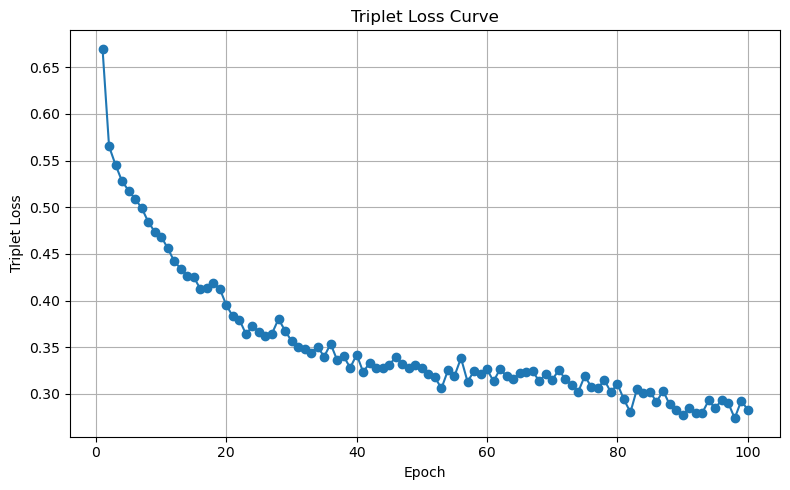


Model saved to 'model.pth'


In [ ]:
base_dataset = AudioFeatureDataset("datasets/vox1_subset_150/val_features")
triplet_dataset = TripletAudioDataset(base_dataset)

model = AudioFusionModel()  
train_triplet(model, triplet_dataset, epochs=100, batch_size=32, lr=0.001, device='cuda')    # Save model

torch.save(model.state_dict(), "voice_model.pth")
print("\nModel saved to 'val_model.pth'")
